In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
#from __future__ import division

In [4]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
import sklearn.linear_model as linear
import numpy.random as random

sns.set(style="whitegrid")

# Model Evaluation and Improvement

## Contents
1. [Introduction](#Introduction)
2. [Two Cultures](#Two-Cultures)
3. [Loss and Evaluation Metrics](#Loss-and-Evaluation-Metrics)
    1. [Regression](#Regression)
    2. [Classification](#Classification)
4. [Cross Validation](#Cross-Validation)
5. [Bias/Variance Tradeoff](#Bias/Variance-Tradeoff)
6. [Model Improvement](#Model-Improvement)
    1. [Learning Curves](#Learning-Curves)
    2. [Validation Curves](#Validation-Curves)
7. [General Rules of Thumb](#General-Rules-of-Thumb)
    1. [Learning Curves and Data](#Learning-Curves-and-Data)
    2. [Validation Curves and Variables](#Validation-Curves-and-Variables)
    3. [Regularization?](#Regularization?)
    4. [Grid Search](#Grid-Search)
    5. [Model Comparison](#Model Comparison)
8. [A/B Testing](#A/B-Testing)
9. [Model Evaluation in the Context of Data Science](#Model-Evaluation-in-the-Context-of-Data-Science)
10. [Summary](#Summary)

## [Introduction](#Contents)

We've discussed two models: Linear Regression and Logistic Regression. Both of these models have a long history in statistics and when talking about them we emphasized mostly the *explanatory* use of those models: interpreting the *importance* of coefficients and trying to determine if the values were *credible* based on the evidence (data). We talked a little bit about the *predictive* function of those models when we looked at linear regression and talked about the $\sigma$ and $R^2$ of the regressions. But the point of view was mostly the statistician's point of view.

In this module, we're going to focus more broadly on model evaluation and improvement. This encompasses two broadly important questions in model development: how good is my model and can I make it better? Note that when we talked about the *explanatory* function of linear regression, we never asked ourself, "could getting more data make the model better?". Now we're going to start to address these kinds of questions.

We'll start with model evaluation from the machine learning point of view which focuses on cross-validation. Cross-validation is a form of *backtesting* that allows you to get a general idea of the performance of your model on new data. It focuses on prediction as the main goal of a model (although it need not exclusively be so).

When we're done with cross-validation, we may have a model with an estimated 9% error rate. We can then ask ourselves, can we make it better? The next section will focus on this question. If we have a model with a certain performance, what should we focus on? The answer is not always, "get more data".

Finally, we'll start to move into a discussion of live testing or A/B testing and the problems that arise with that process both in terms of experimental design and engineering infrastructure.

Obviously, some of these topics bleed back and forth into each other and the process is very iterative. For example, in linear regression we talked about adding key variables, evaluating the model, adding interaction terms, evaluating the model, and so on. Cross validation can certainly fit into this process as it is closely related to bootstrapping.

## [Two Cultures](#Contents)

Although previously we looked at the problem of model evaluation from the statistician's point of view, we're now going to look at the problem from the machine learning researcher's ("machine learning") point of view. As Data Scientists, we must be familiar with both and know when each is appropriate, even using one when a "true believer" might use another. One of the larger failings of current Data Science is to exclude the statistical view entirely.

The outlooks are remarkably different. If you want a glimpse into the different cultures, you can watch Hal Varian's talk [Machine Learning and Econometrics](https://www.youtube.com/watch?v=EraG-2p9VuE) although the audio is quite bad on that recording; there are also [slides](https://web.stanford.edu/class/ee380/Abstracts/140129-slides-Machine-Learning-and-Econometrics.pdf) for the talk which you can peruse.

Taking the case of linear regression, most Machine Learning people will ask:

1. How does it perform on cross validation?
2. What will help improve the performance of the model? More data? Variable transformations? Removing variables?

Whereas a statistician might ask:

1. What is the $R^2$ (or null variance or whatever)?
2. Are the coefficients statistically significant?
3. Do we need to worry about multicollinearity? heteroskedascity?
4. What do the residuals look like?
5. Does the domain offer any suggestions about additional or missing variables, transformations, interaction terms?

As a former economist, I can think of countless studies I've seen published that would have benefitted from 10 fold cross validation but it simply wasn't part of the culture. This is not to say that machine learning cannot learn something from statistics (and especially econometrics, see Hal Varian's talk mentioned above). However, we are going to concern ourselves with a different set of questions here when evaluating a model. Namely,

1. What is the likely error of my model when I apply it to *new* data?
2. How can I make my model better? Where "better" might mean some metric and the "how" might mean:
    1. Get more observations (this doesn't always work).
    2. Get more variables (you might actually need fewer variables) or variable transformations.
    3. Apply regularization (or remove it).
    4. Set a different value for the model's *metaparameters* (parameters of the model not set by using data).
    5. Switch to a different model.
3. Once my model is deployed, how can I evaluate it "in the wild"?

Let's start at the start.

## [Loss and Evaluation Metrics](#Contents)

If we are interested solely in prediction, what does it mean for a model to be good or bad? We talked about this before in terms of the general linearized model but the idea is more general. We could simply predict $y$ by using some constant value of $y$, $\breve{y}$. What $\breve{y}$ should we use? This depends on how much it costs us to be wrong. What "wrong" means depends on the value we're trying to predict or, more generally, if we have a regression problem (predicting a numeric value) or a classification problem (predicting a categorical value).

### [Regression](#Contents)

We talked about loss and regression before. If we define loss (or error) as $y - \hat{y}$ and we wish to summarize this loss over some training set, then we have the following usual suspects:

* **squared loss**

$L(y, \hat{y}) = (y - \hat{y})^2$

* **absolute loss**

$L(y, \hat{y}) = |y - \hat{y}|$

* **0/1 loss**

$L(y, \hat{y}) = 1.0$ if $y = \hat{y}$ else $0.0$

All of these can be turned into a normalized summary statistic by taking the sum and averaging:

$\frac{1}{n} \sum L(y, \hat{y})$

But these aren't the only possibilities. You can use the "usual suspects" such as $\sigma$ or $R^2$ or calculate your own Loss function. 

Imagine that you want to penalize over estimation *more* than underestimation:

$L(y, \hat{y}) =
\begin{cases}
(y - \hat{y})^2,  & \hat{y} > y \\
|y - \hat{y}|, & \text{otherwise}
\end{cases}
$

When we calculate the summary statistic for regression, we have *mean squared error* or MSE and that is the metric we'll be working with most of the time throughout these discussions. However, I do not want you to think that it is the only possible error metric. I should also mention that most linear regression packages minimize MSE and if you want to use your own error, you may need to implement your own regression algorithm (for example, using *stochastic gradient descent*).

### [Classification](#Contents)

Like regression, classification has a baseline for predicting the class value. Assuming the binary case, you would simply predict whichever case is most common (essentially the mode). If 72% of the cases are "1", then you should predict "1". If 58% of the cases are "0", then you should predict "0". This is known as $OneR$. 

The "null" model is often mistaken to be 50/50 in the case of binary classification when it is really $p$ or the probability of $y=1$, which estimated using the frequency of $y=1$ in the data. *That* is the baseline your model needs to beat. Of course it gets a bit dicey when $p$ drops below 0.5. What does that mean? It means you're better off predicting that something is not in the class, which is not necessarily helpful even if it is more accurate.

It is possible to formulate a variety of loss functions for a binary classification task.  *Cross entropy* is one such function and the one used to find the $\beta$s in logistic regression.

$L(y, \hat{y}) = y \times log( \hat{y}) + (1 - y) \times log( 1 - \hat{y})$

and there are [others](https://en.wikipedia.org/wiki/Loss_functions_for_classification). However, I never see these functions used to evaluate classification *models*. They are normally used by the *algorithms* to learn the classification models from data.

Instead, there are a variety of classification *metrics* that are used to evaluate how good or bad a classification model is. As it turns out, there are a number of ways a classification prediction can go right or wrong and different ways to summarize each. For a binary classification task, where "1" is taken to mean "positive" or "in the class" and "0" is taken to be "negative" or "not in the class", the cases are:

1. The true class can be "1" and the model can predict "1". This is a *true positive* or TP.
2. The true class can be "1" and the model can predict "0". This is a *false negative* or FN.
3. The true class can be "0" and the model can predict "1". This is a *false positive* or FP.
4. The true class can be "0" and the model can predict "0". This is a *true negative* or TN.

We can summarize these results in a table called a *confusion matrix*...it summarizes how confused (or not) our model is:

|              | Predict 1 | Predict 0|
|:------------:|:--------:|:---------:|
| **Actual 1** | TP       | FN        |
| **Actual 0** | FP       | TN        |

If N is simply the number of observations TP + FP + FN + TN, then we have the following:

**accuracy** = $\frac{TP + TN}{N}$

**error rate** = $\frac{FP + FN}{N}$

which are the two most common metrics for evaluating classification models. However, they may not be sufficient. The two types of error, classifying something that's "1" as "0" and classifying something that's "0" as "1" may not be symmetric. We saw this when talking about Bayes Theorem. A test may be good at telling you there's a problem if there really is a problem but they also tell you when there's a problem when there really *isn't* a problem, i.e., false alarms.

These various possibilities each have their own names (sometimes several) and can be discussed in terms of the confusion matrix. We're going to look at the three more common ones.

The first is **sensitivity**. This is basically the "disease" case: if you have the disease, how good is the model (test) at detecting it? It is also called **true positive rate**, **hit rate** and **recall**. It is defined only in terms of the positive observations in the data.

$sensitivity = \frac{TP}{TP+FN}$

The next one is **specificity**. This is the other case. If you do not have the disease, how good is the model (test) at deterining that (and not telling you that you do)?

$specificity = \frac{TN}{TN+FP}$

The final case is **precision**  or **positive predictive value**. Basically, of the positive ("1") predictions that we made, how many were right?

$precision = \frac{TP}{TP + FP}$

When we're not looking at accuracy/error rate, we generally look at sensitivity and precision. In fact, there's a harmonic mean of the two called $F1$:

$F1 = \frac{2TP}{2TP + FP + FN}$.

## [Cross Validation](#Contents)

We start with the fundamental assumption of machine learning:

> The data that you train your model on must come from the same distribution as the data you hope to apply the model to.

And there's is no way around this. One million observations of the wrong thing is not going to help you build a model for the thing you want. Assuming you have the right thing, though, how do you calculate a metric for it that gives you an idea of how it will work on unseen data? If you were to *only* calculate the evaluation metric for the data that was used to train the data, you're going to get a slanted view of your model's predictive potential since it was trained to minimize the error on that specific data. Ulimately, we're trying to model the *distributions* from which our data come not a specific data set. 

Taking linear regression as an example, a simple solution would be simply divide your data into two sets, the training set which you use to build the model and the test(ing) set which you use to evaluate the model. This will work but you only end up with one value for MSE. If you switch the roles of the sets, you end up with two.

Borrowing ideas from bootstrapping, there's another option. You could divide your data into ten sections or *folds* and then iterate through each fold, using it as the test set and the others as the training set. You would then end up with 10 estimates of MSE. With 10 estimates of MSE we're back into familiar statistical inference territory: is the MSE meaningful and is the value credible, based on the data.

What this looks like is as follows:

|  1  |  2  |  3  |  4  |  5  |  6  |  7  |  8  |  9  |  10 |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| **Test** | Train | Train | Train | Train | Train | Train | Train | Train | Train |

|  1  |  2  |  3  |  4  |  5  |  6  |  7  |  8  |  9  |  10 |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| Train| **Test** | Train | Train | Train | Train | Train | Train | Train | Train |

|  1  |  2  |  3  |  4  |  5  |  6  |  7  |  8  |  9  |  10 |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| Train| Train | **Test** | Train | Train | Train | Train | Train | Train | Train |

And finally:

|  1  |  2  |  3  |  4  |  5  |  6  |  7  |  8  |  9  |  10 |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| Train| Train | Train | Train | Train | Train | Train | Train | Train | **Test** |


There are other variants of cross-validation such as 3 fold and 5 fold. The *main* consideration is this: is each fold representative of the distribution you're trying to model? This often depends on:

1. How many observations do you have? 300 or 300 million?
2. How many variables do you have? The more variables you have, the "smaller" your data is from a machine learning perspective.
3. How many values can each categorical variable take? Each possible value of a categorical variable is a partitioning of your data. If you have a lot of categorical variables which can each take on many values, your 300 million observations may actually *not* be enough data.

There has been quite a bit of research on cross validation in general and how well it works. From my own vantage point of seeing students (15-30) apply 10 fold cross validation to the same problem, I would suggest doing three (3) applications of 10 fold-cross validation to your data for a total of 30 observations. This is also nice because with 30 observations, you can do bootstrap inference on your data for mean and credible interval (for example).

If you have the computational power, you can perform "cross validation" by simply taking 5%-10% of your data at random, 100 times or more. This ultimately accomplishes the same thing. This is probably the best approach.

Which leads us to one final world of advice: *randomize*. Never use your data just as you found it. Make sure you randomize your data each time before establishing your folds (in other words, *shuffle* your data each time before you designate folds).

## [Bias/Variance Tradeoff](#Contents)

We are now in a position to talk about the general framework for discussing predictive modeling: the bias/variance tradeoff. We will take the case of regression because it is a bit easier to visualize. However, the framework can be formulated for classification problems. If we take our most basic predictive model for regression:

$\hat{y} = \beta_0 + \epsilon$

we can ask ourselves, where does our error $y - \hat{y}$ come from? Conceptually, there are three components of error:

1. **bias** (error) comes from our selection of the model itself, $\beta_0$, which may *underfit* the data.
2. **variance** (error) comes from the sensitivity of $\beta_0$ to outliers which may *overfit* the data.
3. **irreducible error** comes from $\epsilon$ often called "noise", a term I do not like...you can think of it as coming from Rumsfeld's "known unknowns" and "unknown unknowns".

For the most part, we do not have control over **irreducible** error but we may have control over **bias** and **variance**. The problem is that there is generally a *tradeoff*; descreasing one increases the other. Consider a regression problem such as the following:

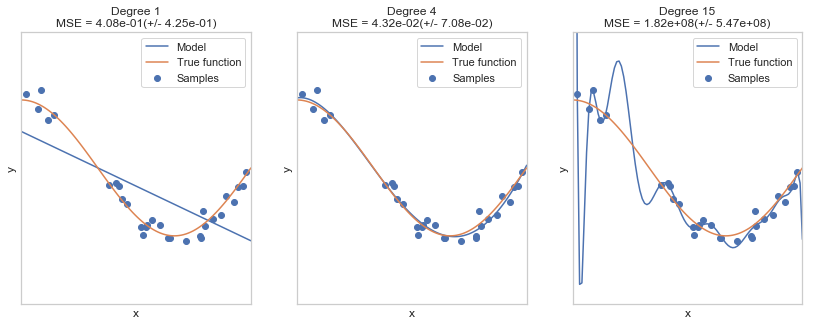

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import sklearn

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

true_fun = lambda X: np.cos(1.5 * np.pi * X)
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline,
        X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))

plt.show()
plt.close()

[source](http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html)

In each panel, we show a sampling of data (dots) from a true relationship (green line) and the resulting model (blue line). The first model is:

$\hat{y} = \beta_0 + \beta_1 x_1 + \epsilon$

The results for this model are shown in the first panel. This model has a mean squared error or MSE of 4.08e-01 on average. Ignoring $\epsilon$ you can think of *bias* as the difference in the blue dots and the blue line (our data and our model) and *variance* as the difference in the green line and the blue line (the real relationship and our model).

We see that both bias and variance are pretty high but as new data points are observed (somewhere along the green line), the model is going to be pretty consistent in its predictions (along the blue line). We generally call this the "high bias/low variance" case. What we're really saying is that our model was very "opinionated" about the kinds of predictions it would make and took less of the shape of the data into account than we might have liked. In essence, we "underfit" the data. This is going to *bias* the error of the predictions.

The third model is:

$\hat{y} = \beta_0 + \beta_1 (x_1^{15}) + \epsilon$

The results for this model are shown in the third panel. We see that bias is quite low...the blue line goes through most of (not all of) the blue dots. But the *variance* is going to be quite high. If you look where there was no data sampled along the green line, the blue line (prediction) is going to be quite wrong in a lot of spots. This is the high variance/low bias case. In a sense, the model was not opinionated enough. We "overfit" the data. There is going to be large *variance* in the error of the predictions.

The second model is:

$\hat{y} = \beta_0 + \beta_1 (x_1^4) + \epsilon$

The results for this model are in the middle panel. Just like Goldilocks, the middle panel shows the case of bias/variance balance. We have not eliminated both types of error. There are cases where the blue dots are quite far from the blue line and there are cases where the blue and green lines diverge. Although it is idealized, it illustrates the concept of what we're aiming for. The problem, of course, is that we can never observe the green line.

So the question becomes, how do you know if you're in panel 1, 2 or 3 and what do you do about it?

## [Model Improvement](#Contents)

So we now have all the pieces we need: metrics, cross-validation and an awareness of the bias/variance trade off in order to think how we might go about improving our model's performance. One can reasonably ask, what are the options?

1. **More observations** This is often the first thing that people think about when a model is not doing well, "we need more data." "More data" can mean two different things: either we need more observations (of the variables we have) or we need more/new/different variables (and values for them). The second case is covered below.
2. ** Number of Inputs** There are sort of two cases here and we need to distinguish once again between data we have (variables) and data we are using (inputs to the model). The first case assumes we have the variables but we need to change the number of inputs by either decreasing or increasing the number of variables we're using as inputs in the model. This might also include adding or removing transformations of those variables. The second case involves getting more data. We've used all the variables and transformations we can think of but we believe there is some feature that our model needs that our variables do not capture. Or perhaps some *proxy* variable is not working as well as we would like.
3. ** Regularization** Many algorithms have the ability to fine tune the "fit" of a model (as in underfitting and overfitting). This is often called *regularization*. If you are using regularization, you may want to turn it up or down.
4. ** Metaparameters** Many algorithms and models use metaparameters. A metaparameter is a parameter that isn't set using data. For example, the threshold value for a logistic regression is a metaparameter.
5. ** Model ** Sometimes we just need to change our model either from a Poisson Regression to a Linear Regression or from a Logistic Regression to a Random Forest. This will almost always involve revisting everything. On the other hand, this may not be an option if our engineering infrastructure is optimized for Decision Trees.

The first thing we need to do is establish where we appear to be in terms of our algorithm, its parameters, the evaluation metric(s) and our data in terms of the bias/variance trade-off. We can do this with learning curves. Learning curves simulate acquiring more data. If getting more data doesn't improve our metrics, we're likely already overfitting.

### [Learning Curves](#Contents)

With learning curves we take the algorithm we have with the existing inputs and metaparameters and simulate what happens when more data is obtained. This becomes our baseline.

There are many variations on Learning Curves and this is but one. I find it's the simplest.

```
1. create subsets of your data of ever increasing size, n% to 100%.
2.     split the subset into a training set (80%) and test set (20%)
3.     train the model using the training set.
4.     using the model, calculate your metric on the training set and test set.
3.     plot n and the two metric values.
```

The Line 1. is probably the most mysterious. You want to simulate what would happen if you got more observations so you take random subsets from your data of ever increasing size...5%, 10%, 15%...all the way up to 100%. For each chunk, you need to split that chunk into a training set and a test set and calculate your performance metric on each (something you don't normally do).

Let's say we're calculating MSE as our performance metric. Then we'd take 5% of our data at random, split 80/20 and calculate the MSE on the training set and the test set. We'd then take 10% of our data at random, split 80/20 and calculate the MSE on the training set and the test set. Repeat until you're at 100% of your training data.

You now have enough data to plot two curves: MSE v. percent of training data, one each for the training set values and the test set values. 

There are other ways to do this. For example, you can start by dividing your data into training and test sets and only chunk the training set, using the same test set throughout. This fits well with using cross validation although once you start using 10 fold cross validation you need to start averaging the results of your curves. That can get a little complicated. Nevertheless, there are other options.

#### Example with Linear Regression

Consider the following (unobserved) relationship:

$y = 3.89 + 2.48 \times x_1 - 5.58 \times x_2 + 1.98 \times x_3 + \epsilon( 0, 2.75)$

where $x_2 = x_1^2$.

In [6]:
data = {}
#data[ "x1"] = np.array( [random.uniform(-1.0, 1.0) for i in range( 0, 1000)])
#data[ "x2"] = data[ "x1"]**2
#data[ "x3"] = np.array( [random.uniform(-1.0, 1.0) for i in range( 0, 1000)])
#epsilon = np.array([ random.normal( 0.0, 1.45) for i in range( 0, 1000)])
data[ "x1"] = stats.norm.rvs(10.0, 2.5, 1000) #np.array( [random.uniform(-1.0, 1.0) for i in range( 0, 1000)])
data[ "x2"] = data[ "x1"]**2
data[ "x3"] = stats.norm.rvs(15.0, 3.8, 1000) # np.array( [random.uniform(-1.0, 1.0) for i in range( 0, 1000)])
epsilon = stats.norm.rvs(0, 2.45, 1000) # np.array([ random.normal( 0.0, 1.45) for i in range( 0, 1000)])

data[ "y"] = 3.89 + 2.48 * data[ "x1"] - 4.58 * data[ "x2"] + 1.98 * data[ "x3"] + epsilon
data = pd.DataFrame( data)
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
x1    1000 non-null float64
x2    1000 non-null float64
x3    1000 non-null float64
y     1000 non-null float64
dtypes: float64(4)
memory usage: 31.3 KB
None
          x1          x2         x3           y
0   8.722987   76.090505  14.407109 -296.618344
1   7.048420   49.680218  18.986554 -166.420097
2   9.929544   98.595853  27.049704 -369.283512
3  11.070830  122.563270  15.720099 -498.261442
4  10.166293  103.353514   9.876030 -427.196934


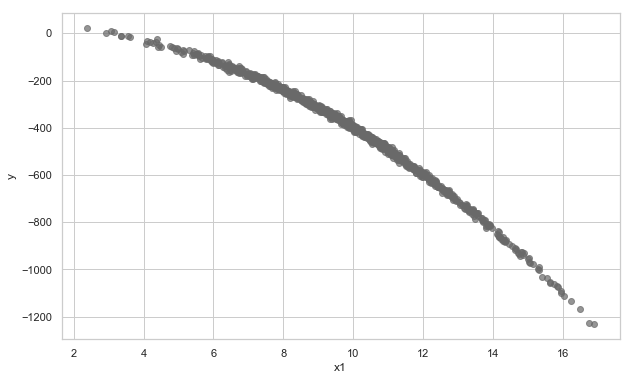

In [7]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( data[ "x1"], data["y"], marker="o", color="dimgray", alpha=0.7)
axes.set_ylabel( "y")
axes.set_xlabel( "x1")

plt.show()
plt.close()

In [8]:
def lm( formula, data=None):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")

    result = {}
    result[ "formula"] = formula
    result[ "n"] = data.shape[ 0]

    y, X = patsy.dmatrices( formula, data, return_type="matrix")
    model = linear.LinearRegression( fit_intercept=False).fit( X, y)

    result[ "coefficients"] = model.coef_[ 0]

    result[ "r^2"] = model.score( X, y)
    
    y_hat = model.predict( X)
    result[ "residuals"] = y - y_hat
    
    sum_squared_error = sum([ e**2 for e in result[ "residuals"]])[ 0]

    n = len( result[ "residuals"])
    k = len( result[ "coefficients"])
    
    result[ "sigma"] = np.sqrt( sum_squared_error / (n - k))
    
    return result

In [9]:
result = lm( "y ~ x1", data=data)

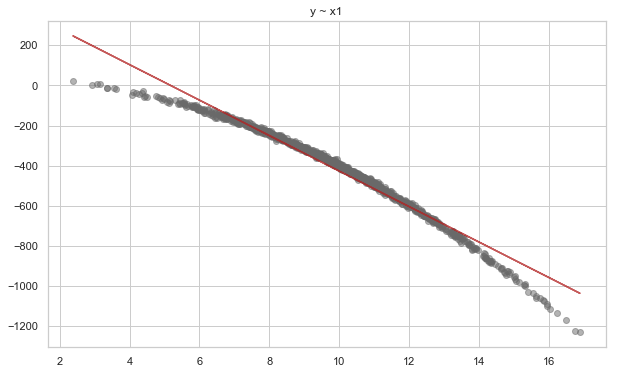

In [10]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

xs = data[ "x1"]
ys = data[ "y"]
axes.scatter( xs, ys, color="dimgray", alpha=0.5)
betas = result[ "coefficients"]
axes.plot(xs, [betas[ 0] + betas[ 1] * x for x in xs], '-', color="firebrick", alpha=0.75)
axes.set_title( result[ "formula"])

plt.show()
plt.close()

In [11]:
def mse( errors):
    n = len( errors)
    squared_error = np.sum( [e**2 for e in errors])
    return np.sqrt((1.0/n) * squared_error)

print(mse( result[ "residuals"]))

39.05198441744862


I've adjusted the mean squared error here to be sort of mean error so that the units are in the same units as $y$. We can see that the model is off by about 2 units on average and that's great given the range of the values of $y$.

Will getting more data help?

Let's follow the formula for learning curves above. Basically, we need two functions. The first function does cross-validation with some data by taking a fixed percentage of the data as the test set, fitting the model and estimating the performance metric some number of times (this could be re-written to be more general). The second function does the learning curves. Then we'll plot them.

In [12]:
from copy import deepcopy

def cross_validate( formula, data, test_size=0.20):
    training_mses = []
    test_mses = []
    
    n = data.shape[ 0]
    test_n = int( np.round( test_size * n, 0))

    indices = deepcopy( data.index).values
    random.shuffle( indices)

    test_indices = indices[ 0:test_n]
    training_indices = indices[test_n:]

    test_set = data.ix[ test_indices]
    training_set = data.ix[ training_indices]

    y, X = patsy.dmatrices( formula, training_set, return_type="matrix")
    model = linear.LinearRegression( fit_intercept=False).fit( X, y)
    y_hat = model.predict( X)

    training_mse = mse( y - y_hat)

    y, X = patsy.dmatrices( formula, test_set, return_type="matrix")
    y_hat = model.predict( X)

    test_mse = mse( y - y_hat)

    return training_mse, test_mse

In [13]:
cross_validate( "y ~ x1", data)

(39.71614427036566, 36.586688074969125)

In [14]:
def learning_curve( formula, data, increment=0.05, iterations=100, test_size=0.20):
    increments = int( 1.0/increment)
    chunks = [ int(x) for x in np.linspace( 0, data.shape[ 0], increments)][ 1:]
    train = []
    test = []
    for chunk in chunks:
        train_chunk = []
        test_chunk = []
        for i in range( iterations):
            indices = list(range( data.shape[ 0]))
            random.shuffle( indices)
            chunk_indices = indices[0:chunk]
            data_chunk = data.ix[ chunk_indices]
            train_mse, test_mse = cross_validate( formula, data_chunk, test_size=test_size)
            train_chunk.append( train_mse)
            test_chunk.append( test_mse)
        train.append( np.mean( train_chunk))
        test.append( np.mean( test_chunk))
    return chunks, train, test

In [15]:
chunks, train, test = learning_curve( "y ~ x1", data, increment=0.01)

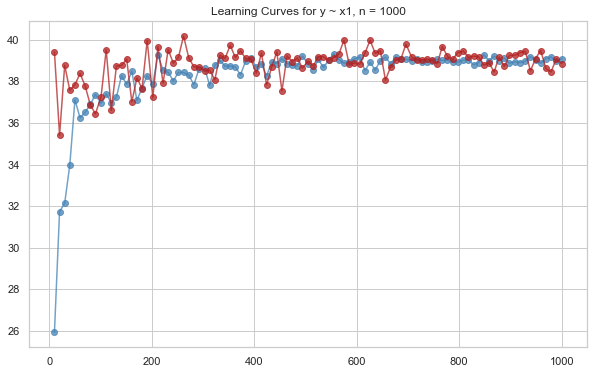

In [16]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.plot( chunks, train, 'o-', color="steelblue", alpha=0.75)
axes.plot( chunks, test, "o-", color="firebrick", alpha=0.75)

axes.set_title( "Learning Curves for y ~ x1, n = 1000")


plt.show()
plt.close()

Unfortunately, learning curves rarely look as good in real life as they do in textbooks.

We can see at the start, when we're using only a very small fraction of the data set (10 examples), that the difference in MSE between the training set (blue dot) and test set (red dot) is relatively large. This is called the *generalization error*.

This makes sense. The model is being fit using relatively little training data so it's overfitting and then not performing very well on the test data. As we increase the amount of our data we're using, the MSE on the training set (blue line) starts to increase. This also makes sense because we're building a more general model as we have more data to generalize over.

At the same time, the MSE on the test set (red line) is decreasing. If we have more data to build a model with, the model will generalize better and thus do better on the test set. That's what we want.

At 1000 data points, the far right, we're using all of the data we have. The lines have more or less converged. This means that getting more data won't help us to improve this model. Note that that means *this* model...including its hyperparameters, regularization, etc. If we change those, we may or may not need more data. But for now, it appears we don't.

To bring this back to the bias/variance trade off, when the two curves are far apart, we're in the *high variance* area. We're overfitting our model to the (small) amount of data. In the limit, with two data points for the training set, we fit the data perfectly.

When the two curves are closer together, we're in the *high bias* area. The more data we have, the more the error comes from the form of the model. In the limit, the new data simply isn't change the model much or at all.

As a practical matter, it's possible for your learning curves to be even more jagged, if this happens decrease the size of your chunks. For example, if you're working with 10%, 20%, 30%...100% sized chunks then move to 5%, 10%, 15%, 20%, 25%...100% sized chunks.

To get a better idea of what's going on, imagine that we only had 50 data points and we did learning curves:

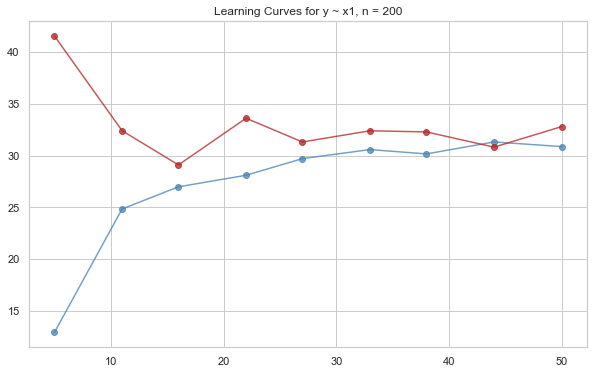

In [17]:
chunks, train, test = learning_curve( "y ~ x1", data[0:50], increment=0.10)

figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.plot( chunks, train, 'o-', color="steelblue", alpha=0.75)
axes.plot( chunks, test, "o-", color="firebrick", alpha=0.75)

axes.set_title( "Learning Curves for y ~ x1, n = 200")

plt.show()
plt.close()

Here you can see that the curves have not converged (although they're very close). This suggests that getting more data will help the performance of our model. You can see the same thing in the original chart by looking the curves before 200 data points. You can also see that getting more data doesn't help. That sometimes happens, too.

These graphs are closer to the textbook ideal:

![](resources/images/080/high_bias.png)

![](resources/images/080/high_variance.png)

### [Validation Curves](#Contents)

The basic idea behind validation curves is the same as learning curves. We vary something (regularization, training epochs, variables, transformations) and see how our performance metric does on the training set compared to the test set. It helps to know that the test set is also called the validation set...hence, *validation curves*.

Of course, one big difference is that because we're not trying to simulate getting more data, we will use all of it for the validation curves. Let's look at the case where we investigate different polynomial transformations of $x_1$.

Let's add $x_1^2...x_1^5$ to the `data` remembering that we don't know that $x_2$ *is* $x_1^2$. We're also going to re-add $x_1^1$ using the same notation:

In [18]:
data[ "x_1"] = data[ "x1"]**1
data[ "x_2"] = data[ "x1"]**2
data[ "x_3"] = data[ "x1"]**3
data[ "x_4"] = data[ "x1"]**4
data[ "x_5"] = data[ "x1"]**5

We want to do the same basic `cross_validation` function except we want to use a different model each time with successively larger polynomial values of $x_1$:

$\hat{y} = \beta_0 + \beta_1 x_1$

$\hat{y} = \beta_0 + \beta_1 x_1^2$

$\hat{y} = \beta_0 + \beta_1 x_1^3$

$\hat{y} = \beta_0 + \beta_1 x_1^4$

$\hat{y} = \beta_0 + \beta_1 x_1^5$

We want to find the highest order term that improves the performance of the model. We could also, theoretically, start testing lower order terms after that but we'll still with the highest for now.

In [19]:
def validation_curves( formulas, data, iterations=100, test_size=0.2):
    train = []
    test = []
    for formula in formulas:
        train_chunk = []
        test_chunk = []
        for i in range( iterations):
            train_mse, test_mse = cross_validate( formula, data, test_size=test_size)
            train_chunk.append( train_mse)
            test_chunk.append( test_mse)
        train.append( np.mean( train_chunk))
        test.append( np.mean( test_chunk))
    print(train)
    print(test)
    return train, test

In [20]:
xs = [1, 2, 3, 4, 5]
train, test = validation_curves(["y ~ x_1", 
                                 "y ~ x_2", 
                                 "y ~ x_3", 
                                 "y ~ x_4", 
                                 "y ~ x_5"], data)

[38.99223679398558, 7.769651227286755, 31.906023243783594, 59.006420303043434, 82.03970078615042]
[39.24118472103882, 7.75539434753492, 31.827944971580596, 59.31948786130066, 84.37521781426207]


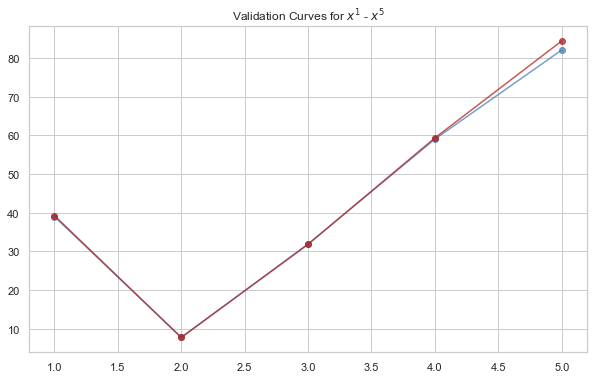

In [21]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.plot( xs, train, 'o-', color="steelblue", alpha=0.75)
axes.plot( xs, test, "o-", color="firebrick", alpha=0.75)

axes.set_title( "Validation Curves for $x^1$ - $x^5$")

plt.show()
plt.close()

The validation curve shows that using the higher order term, $x_1^2$, decreases MSE.

Again, this isn't how textbook validation curves are supposed to look but they rarely do. The general idea is that you are moving from high bias to high variance as you move from left to right. We start out at high bias because we are underfitting the training data and generalizing poorly. At the other end of the spectrum, we are in the high variance zone because we are overfitting the data and generalizing poorly. The minimum should be the location where bias and variance are balanced.

In general, blue curve should be high and decreasing and the red curve should be U shaped...so much for textbooks.

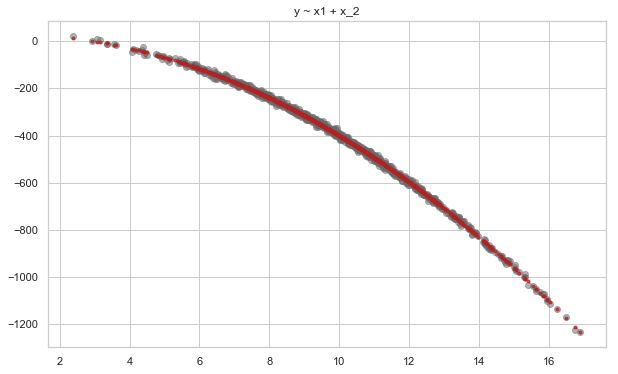

In [22]:
result = lm( "y ~ x1 + x_2", data=data)

figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

xs = data[ "x1"]
ys = data[ "y"]
axes.scatter( xs, ys, color="dimgray", alpha=0.5)
betas = result[ "coefficients"]
axes.plot(xs, [betas[ 0] + betas[ 1] * x + betas[ 2] * x**2 for x in xs], '.', color="firebrick", alpha=0.75)
axes.set_title( result[ "formula"])

plt.show()
plt.close()

Having found a new point in the input space (adding a quadratic term), we need to find out if our conclusion still holds for not needing more data...

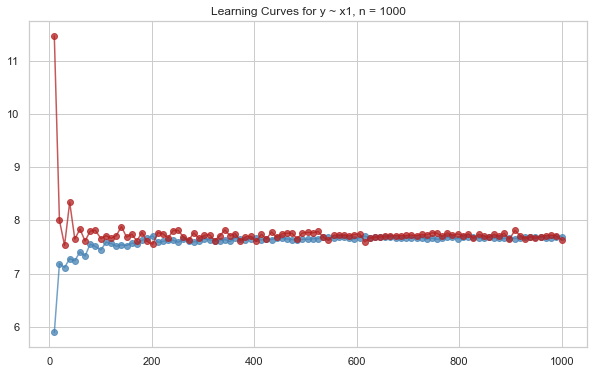

In [23]:
chunks, train, test = learning_curve( "y ~ x1 + x_2", data, increment=0.01)
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.plot( chunks, train, 'o-', color="steelblue", alpha=0.75)
axes.plot( chunks, test, "o-", color="firebrick", alpha=0.75)

axes.set_title( "Learning Curves for y ~ x1, n = 1000")

plt.show()
plt.close()

And it appears that it does.

## [General Rules of Thumb](#Contents)

Given a model, data set, inputs, regularization, and metaparameters, you may find that the model doesn't do as well as you like or you'd like it to do better based on an evaluation metric or metrics. Learning and validation curves along with exploratory data analysis (EDA) can help you decide what to do next.

### [Learning Curves and Data](#Contents)

If you are in the high bias area of learning curves, getting more observations will *not* help. If you are already in the high bias (underfitting) zone of your data and model, getting more data will not fix problem because most of your error comes from the model, not the data.

On the other hand, if you are in the high variance area of the learning curves, getting more data *may* help. At this point the model is overfitting the data and getting more of it will help the model generalize.

### [Validation Curves and Variables](#Contents)

More data is not the only thing that may improve model performance. Validation curves can help you determine which transformations, metaparameters, inputs and regularization is best for your problem.

#### High Bias/Underfitting

If you are underfitting, generally you can improve your model by:

1. Adding additional inputs (new variables, transformations of existing variables).
2. Decreasing regularization.

#### High Variance/Overfitting

1. Removing inputs (remove variables, transformations, et.)
2. Increase regularization.

### [Regularization?](#Contents)

Regularization is an addition to the loss function that penalizes weights. Our MSE loss function has been:

$L(y, \hat{y}) = \frac{1}{n} \sum (y - \hat{y})^2$

but really, $L$ is a function of our weights:

$L(y, \beta) = \frac{1}{n} \sum (y - \beta X)^2$

Linear regression, for example, will find some value for $\beta$ no matter what (as will most related approaches including neural networks, support vector machines, etc). We encourage the algorithm to penalize trivial values for any given $\beta_i$ by adding a term to our loss function basically adds up the $\beta$s. The algorithm will find lower values for the $\beta$s than it otherwise would and overfitting will be reduced.

$L(y, \beta) = \frac{1}{n} \sum (y - \beta X)^2 + \lambda \sum \beta_i^2$

How *much* $\beta$s are penalized depends on the value of $\lambda$ and a good value for $\lambda$ is something that can be found with validation curves. On the spectrum of bias/variance trade-off, $\lambda$ is another knob to turn...or add if you're not using it and you're overfitting.

While regularization is the general way of controlling for overfitting in models using weights, other algorithms have similar capabilities such as pruning for decision trees and priors for bayesian networks.

### [Grid Search](#Contents)

Some of you may be familiar with grid search. Grid search occurs when you vary many of these "knobs" at the same time forming a hypergrid of metaparameter, feature and regularization options.

Validation curves are largely the same thing.

### [Model Comparison](#Contents)

There is one possibility that we haven't talked about: switching models. "Switching models" is kind of ambiguous. What do I mean?

1. Switching from $\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2$ to $\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3$ or
2. Switching from linear regression to a neural network.

The answer is *either*. The first we can call "changing inputs" and the second we'll call "changing models".

#### Changing Inputs

From a statistical point of view, when we looked at linear regression, we saw that we had $R^2$ and $sigma$ to guide us in terms of better models. From a machine learning point of view, though, we have cross validation and a variety of evaluation metrics. Since we are only interested in predictive power, the better model is the one with a *difference* in MSE (for example) that is larger, *meaningful* and *credible*. Sound familiar?

We've already seen how to approach a problem like this. We just use the cross-validation data to perform statistical inference using the non-parameteric Bayesian bootstrap.

#### Changing Models

If you have a certain error level that is unacceptable, you may be inclined to change models. For clarity, we'll note that an algorithm (gradient descent against squared error) builds a model ($\beta$s) from data (numerical and binary inputs). For example, the id3 algorithm builds decision trees from data. The model is the decision tree. We could, of course, build a neural network instead. So you are both changing the learning algorithm and the model.

How you generally proceed will depend on a number of factors.

First, not all models can accept all variable types. Some algorithms need to have categorical variables encoded as binary values and some do not. Otherwise need numeric variables. These will be additional transformations aside any re-expression you might want to do later. This may put a new load on ETL infrastructure, timelines, etc. Patterns that exist in under one transformation (numeric) may not exist under another transformation (ordered categories). You will probably need to repeat your EDA.

Second, how is the model being used? If you're just running the model yourself, either on-demand or using a cron job, you are probably free to do as you like and to add whatever libraries you like. However, if you are building models that need to be "put into production" you may need to coordinate with other engineers to see if you can deploy the model you plan to build. This can get messy. Is there code to generate run algorithm X in language Y? If not, does your engineering department know how to support R code in production? Can you write code to evaluate the model in language Y and simply export the parameters from R? The answers to these kinds of questions fall in the general purview of "data products".

Third, you may very well find yourself in the same boat with respect to performance after you've taken the time translate all your data into a form another learning algorithm can handle. Generally speaking, your time may often be better spent looking for better features than different algorithms.

How all of these factors play--and whether you take them into account from the start--determine your options and process. If you are limited in the kinds of models you can use, you'll follow the flow described here more closely. Changing models only when absolutely necessary. If you have a lot of modeling options and plan ahead, you may already have variables and transformations of variables available to try a wide variety of models.

Taking all of this into account, you may still feel that a regression tree is better than linear regression for your problem, how do you decide which is better?

Assuming you've made all the necessary transformations and performed cross-validation, we're back to a familiar problem: is the difference meaningful and credible given the data? We already know how to answer that. Whether or not the difference is meaningful depends on your particular situation and the input of domain experts and stakeholders (all of which might be you but don't presume they're you).

For example, you might have two models with an apparent difference in MSE is worth changing ETL scripts, retooling and asking engineers to spend four weeks re-writing, testing and deploying code and *means something to the organization* usually by increasing efficiency, increasing revenue or decreasing costs. Alternatively, the result might just end up in a report.

In either case, there is a statistic of interest (the difference in mean squared error) that you want to infer and you already have the tools to solve that problem whether it is the difference in mean squared error (difference of two values) or difference in accuracy (difference of two proportions). Use the Bayes, Luke.

## [A/B Testing](#Contents)

There's only so much you can do with cross validation and learning curves to test the generalization performance of your latest "superfantastic" model. Additionally, there are some approaches for which backtesting is either infeasible or impossible. At some point you're going to have to let the model out into the wild and see what it can really do. But should you just shelve your current model? Should you unleash this superfantastic model on all your customers? Probably not. Instead you should conduct an A/B test.

An A/B test is not unlike the process used in medicine for testing new treatments. In the typical medical situation, there's a current treatment and standards of care. A company might come up with a new drug. Doctors don't simply start prescribing the new drug. Instead, there are randomized clinical trials. A drug company will recruit a number of patients and randomly assign them to two groups: the "control" group and the "treatment" group. Control will get the existing treatment (or a placebo if there is no current treatment) and Treatment will get the new drug. At the end of the trial, the statistics are calculated (you do have an evaluation metric, right?) and then we're back in familiar territory: do we have a *meaningful* difference (in medicine, defined as a clinically significant result) and do we have a believable difference--we do statistical inference.

We can do the same thing for, really, any process change. Suppose we send out a marketing letter every year to raise funds for our non-profit. This year we want to see if adding a hand written note increases the response rate and the contribution amount. We can take our donor list, randomize it and send one-half the regular fundraising letter and the other half the fundraising letter with the hand written note. We can tally the results and see if the differences are meaningful and believable.

I bring up this entirely non-computer example because this might be a situation that you run into when doing data science. The actual process may be entirely manual, old-school snail mail but you will be asked to structure and evaluate the experiment.

In general, however, we are more likely to be working with new and improved models and A/B testing these models often requires a complicated infrastructure. Suppose we are send our customers emails every month to let them know what's on sale. We currently pick the 20 most popular items but we have a good idea that if we could personalize the email to cover the kinds of things each customer is more likely to buy, we will generate more revenue. We spend a few months developing a personalization model and decide we want to A/B test it.

Before we can even do that, we need an infrastructure that:

1. keeps track of every email sent and whether or not that person opened it (email services can do this; you may need to download the information through their API).
2. assigns each customer into either control or treatment (A or B) and keeps track of it.
3. can tie an email address to a customer purchase (easy on a website, not as easy in a brick-and-mortar store).
4. generates the personalized content and keeps track of it (either in advance or on-the-fly depending on the scale and resources).
5. monitor our services so that we know that emails are going out and that personalized content is being generated and used.
6. collects results.

From an experimental design perspective, we have a few complications and options. If we are applying Frequentist inference, we have quite a few guidelines that we *must* follow for the test to be accurate.

1. We must, of course, set a level of significance ahead of time.
2. We must determine the differences in purchase rates and revenue that are meaningful to us; generally, differences that make the development, deployment and maintenance of the model and infrastructure cost effective.
3. Given the minimum difference in purchase rates ("lift") we want to detect, select an appropriate sample size: how many emails do we need to send out before we can detect our minimum lift?
4. We should not, generally, peek at the results (we should not do a test of statistical significance) before the experiment is over. We may need to monitor our test, though, to make sure emails are being sent, etc.
5. We should not, generally, stop the test early because we see favorable results.

There is a "generally" in the last few points because it is possible to build the ability to peek and stop early into your experiment when using Frequentist inference. However, you *must* do it ahead of time. That is, if you find you need 10,000 samples to detect a minimum 5% lift and that it will take four weeks to obtain that many samples, you must build into your test plan the fact that you will "peek" at one week, two weeks, three weeks and, finally, a four weeks. This peeking generally includes having a stronger criteria for statistical significance known as "early stopping".

Why? If you peek at your data at one week and it is statistically significant, how do you know that the data wouldn't turn the other way in another week?

This is actually a problem in clinical trials as well. What if everyone in Group B is healed completely and everyone in Group A (the original treatment) is still dying? Do you wait until the test is over? In general, there are two ways that medical research handle this problem. First, they include "early stopping" criteria in their experimental design or they use Bayesian inference from the start.

And that brings us to Bayesian inference. Under Bayesian inference, you still need to establish meaningful differences (lift) but you can use the estimate of the Posterior distribution at any time to evaluate the believability of your results. If you stop at 10 observations or 10,000 observations that is simply your responsibility. This is kind of daunting actually.

One very effective practice is to be running A/A tests all the time for the situations where you might apply models. An A/A test is pretty straight forward. You do assign people at random to two groups--but you give them both the control! As you analyze this data as if it were an A/B test, you can test your infrastructure for correctness and you can also assess the size of the lift you generally see in that situation. You can then use this as a prior.

A/B Testing brings in a whole new world of concerns.

One of these is data leakages. Your current data on people buying from emails is *biased* based on the way the current email is constructed. For example, if your email includes the 20 most popular items for your store, then the items people see and the purchases they make from the email are biased by that. If you go to use this data for *backtesting* this has an inherent bias towards popularity. If you tried to develop and backtest a model that was based on personal preferences, it might not work as well simply because it has to work against the bias in the data.

The only way around this sort of bias is to pick a small segment of your users and send them a *random* product listing in their email and only use this data for backtesting. (Don't keep those customers in the "random" group from month to month if you want to keep them).

You also have problems with *attribution*. If you send a weekly email and I see Product A in the email for week 1, and I see it in the email for week 2, and I buy it in week 3...which email caused me to buy Product A? Maybe it was both emails? There isn't usually a right or wrong answer, but you must be consistent.

You need to also worry about overlapping and interacting tests. It is usually not a problem if someone is in an email test group and a site test group...but if someone is in a green/blue button test group *and* a dark/light theme test group, that might be a problem.

You also are up against something like the placebo effect called "novelty effects". A treatment might have a significant lift simply because it is new. If you need to run a four week A/B test, and you find that B is better after four weeks, you should consider running a second test.

Finally, you must make sure that your groups do not contain biases. Consider what happens if Group A contains all women and Group B contains all men? Or if Group A contains established clients and Group B contains new acquisitions? As R. A. Fisher was fond of repeating, the single most important thing you can do is "Randomize! Randomize! Randomize!".

In recent years, *Bandit Optimization* has arisen as a possible alternative to A/B testing. In Bandit optimization (which is related to *reinforcement learning*), you assign a model (control or treatment) to a user based on the probability of the model is any good, subject to a minimum. How does that work?

First, let's start with control and treatment. We assign them to users with a 50/50 probability. As results come in, we can adjust those probabilities based on the purchases. If there are more purchases with B, the probability of assigning B increases and the probability of assigning A decreases. If B starts to lose against A, the probability of assigning B starts to decrease. There is usually a floor of some kind, say, five percent.

Now, when we introduce a new model, we renormalize our probabilities to include the new model at, say, 10% so we have A with a 85% probability, B with a 5% probability and C with a 10% probability. If C is really better than A or B, the probability of assigning C will go up.

What does this give you? If it turns out that some fluctuating circumstance made B look better than A, as that circumstance passes, the probability of picking B will go down because it will stop being better. This takes care of the novelty effects. Additionally, there might be seasonal effects. Maybe B did well in the Spring and when Spring ends, the probability of picking B goes down and when Spring returns, the probability of picking B goes up again. All without human intervention.

The downsides to Bandit Optimization is that you need a fairly large amount of traffic for it to work and it doesn't necessarily pick a clear winner. If you need a clear winner, use A/B testing.


## [Model Evaluation in the Context of Data Science](#Contents)

Model evaluation takes on an entirely new dimension for the Data Scientist. At some point, someone will say to you, "we want to increase engagement" and that's fine, except that we need to agree on what that means in a very concrete way. Does it mean time on the page or number of pages visited? You need to see if that data is being collected and if it can be calculated. This should have been part of the original CoNVO or subsequent improvements to the understanding of the problem. It may have been missed.

Let us take an example from the very first module, you have a news site and you want people to read the articles. One way you think you can do that is to build a model that scores each story for each individual, producing a propensity to read the story. This is a complex classification/information retrieval problem. So when building the model, you might conduct some cross validation studies to see how well the model performs.

But "reading propensity" may not be the metric you're trying to optimize. So in the A/B Test, the performance metric diverges from the loss function and performance metric of the model. Your organization may have a whole slate of engagement scores. Your model was not built to optimize all of those and in a dynamic context.

Put differently, there's a difference between the estimation of response variables (and associated loss functions) and evaluation metrics. The response variable of your model may be the probability that someone buys a certain product. The evaluation metric of the model may be purchase rates. These are not the same thing.

A/B Testing may ultimately be used to test what is more important and only validates the model in a very indirect sort of way.

## [Summary](#Contents)

Here are a few take away points:

1. High Bias/High Variance are not absolutes. There is no algorithm that produces models that are always high bias. High bias or variance exist in context with the inputs, metaparameters, and data.
2. There is a lot of trial and error in "debugging" a machine learning model. It's a very large search space of possibilities. Use EDA to inform your search. We knew to try a quadratic transformation on $x_1$ because we'd looked at the data. Note that some companies, DataRobot for example, are trying to automate the process by automatically searching the grid of possibilities using huge clusters in the cloud. You  might be able to accomplish something similar on your own.
3. Real life curves--learning or validation--rarely look as neat as the textbook versions.

## Review

1. Describe the two cultures of model evaluation. How are they different?
2. What is the most typical evaluation metric for regression (value prediction) problems? What is the formula?
3. What is a confusion matrix? What are each of the elements in the matrix?
4. Define and provide the formula for:
  1. accuracy
  2. error rate 
  3. sensitivity/true positive rate
  4. specificity
  5. precision
5. How does 10 fold cross validation work? How would you apply it to linear or logistic regression?
6. What is the bias/variance tradeoff?
7. How does bias relate to underfitting?
8. How does variance relate to overfitting?
9. What are the five general ways in which a "model" can be improved?
10. Describe how to calculate learning curves. What do they tell you about your model?
11. What do learning curves look like when your current situation involves high bias?
12. What do learning curves look like when your current situation involves high variance?
13. If your learning curves indicate high bias, what does that suggest about getting more data? What should you do?
14. If your learning curves indicate high variance, what does that suggest about getting more data? What should you do?
13. What are validation curves used for? How do you interpret them?
14. What are some other ways you can improve your model under high bias/high variance?
15. What is regularization?
16. What is the difference between "backtesting" and A/B testing?
  